In [1]:
import numpy as np
import cupy as cp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scattering

/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


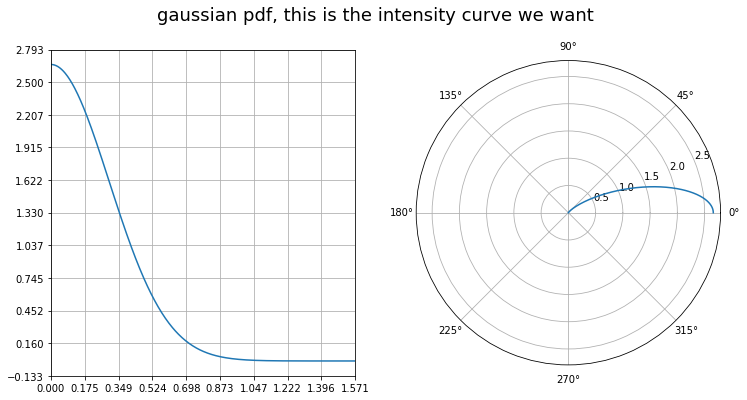

In [2]:

def sample_pdf(size,  pdf_x, pdf_y):
    """Given a pdf, produce samples."""
    cdf = np.cumsum(pdf_y)
    cdf = cdf / cdf[-1]
    
    rng = cp.random.default_rng()
    values = rng.random(size)
    value_bin = cp.searchsorted(cdf, values)
    random_from_cdf = pdf_x[value_bin]
    return random_from_cdf

pdf_samples = cp.linspace(0, np.pi/2, 512)
norm_pdf = cp.array(scipy.stats.truncnorm.pdf(x=pdf_samples.get(), a=0, b=np.inf, scale=0.3))

fig = plt.figure(figsize=[12,6])
plt.suptitle("gaussian pdf, this is the intensity curve we want", fontsize=18)
ax = plt.subplot(121)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
plt.plot(pdf_samples.get(), norm_pdf.get())
ax = plt.subplot(122, projection='polar')
plt.plot(pdf_samples.get(), norm_pdf.get())
plt.show()

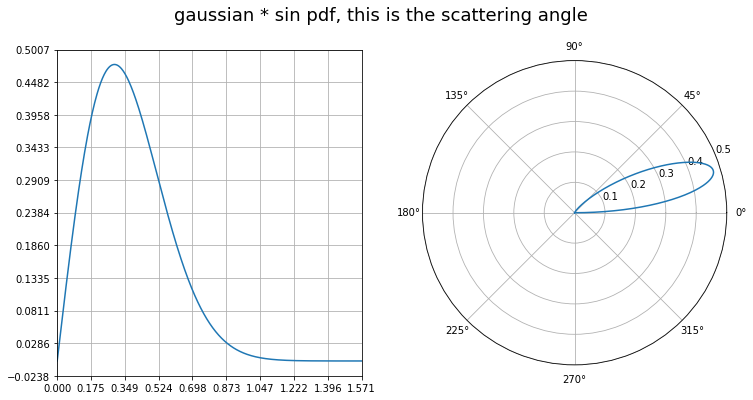

In [3]:
norm_sin_pdf = cp.array(norm_pdf) * cp.sin(cp.array(pdf_samples))

fig = plt.figure(figsize=[12,6])
plt.suptitle("gaussian * sin pdf, this is the scattering angle", fontsize=18)
ax = plt.subplot(121)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
plt.plot(pdf_samples.get(), norm_sin_pdf.get())
ax = plt.subplot(122, projection='polar')
plt.plot(pdf_samples.get(), norm_sin_pdf.get())
plt.show()

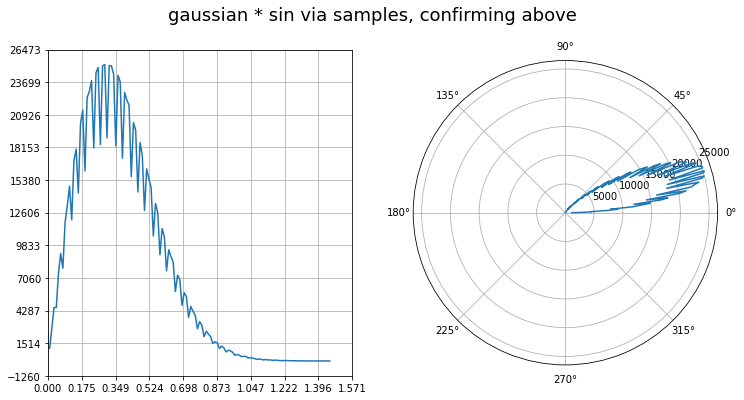

In [4]:
norm_sin_samples = sample_pdf(1000000, pdf_samples, norm_sin_pdf)
h,b  = cp.histogram(norm_sin_samples, 128)
bc = (b[:-1] + b[1:])/2

fig = plt.figure(figsize=[12,6])
plt.suptitle('gaussian * sin via samples, confirming above', fontsize=18)
ax = plt.subplot(121)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
plt.plot(bc.get(), h.get(), snap=False)
ax = plt.subplot(122, projection='polar')
plt.plot(bc.get(), h.get(), snap=False)
plt.show()

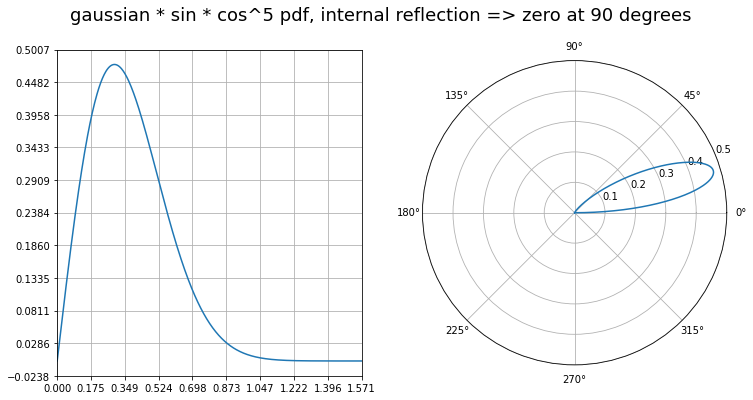

In [5]:
schlick = 1 - (1 - cp.cos(pdf_samples)) ** 5 # really zero at 90deg
norm_sin_schlick_pdf = norm_pdf * cp.sin(pdf_samples) * schlick

fig = plt.figure(figsize=[12,6])
plt.suptitle("gaussian * sin * cos^5 pdf, internal reflection => zero at 90 degrees", fontsize=18)
ax = plt.subplot(121)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
plt.plot(pdf_samples.get(), norm_sin_schlick_pdf.get())
ax = plt.subplot(122, projection='polar')
plt.plot(pdf_samples.get(), norm_sin_schlick_pdf.get())
plt.show()

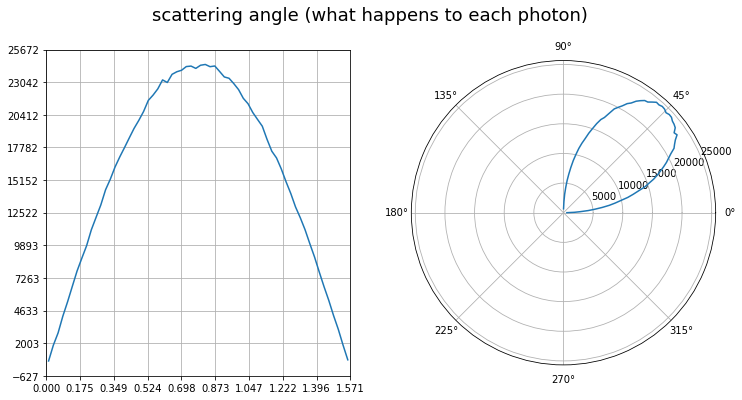

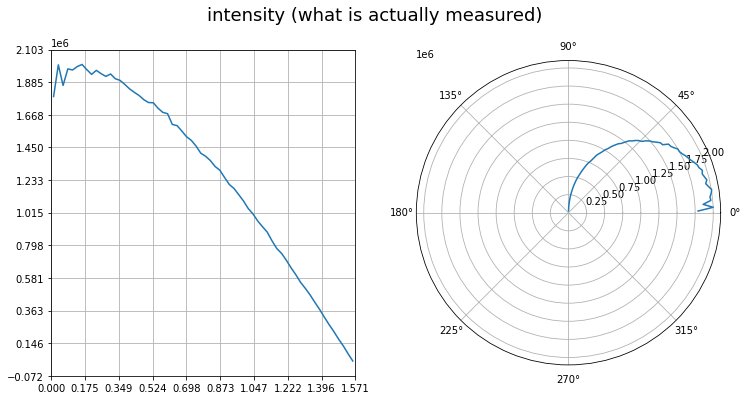

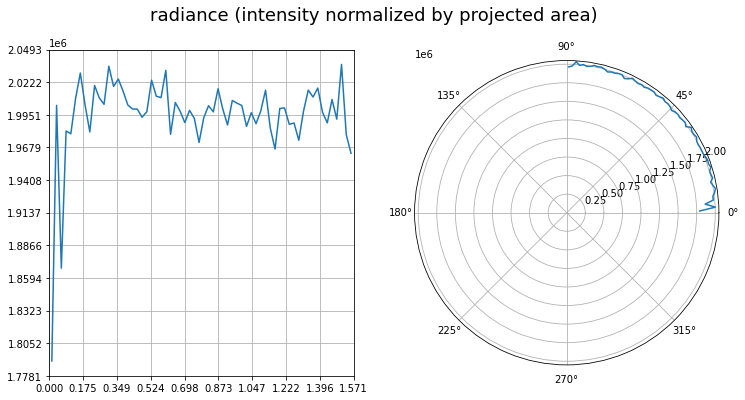

In [6]:
size = 1000000 # 1e6
rng = cp.random.default_rng()
#theta = cp.arccos(rng.uniform(-1,1,size)) # isotropic
theta = cp.arccos(2 * rng.random(size, dtype=np.float32) - 1.0)/2 # lambertian
#theta = sample_pdf(size, pdf_samples, norm_sin_schlick_pdf) # yields gaussian intensity
#theta = scattering.get_scattering_theta(0.2, size).get() # henyey greenstein

h,b  = np.histogram(theta, 64)
bc = (b[:-1] + b[1:])/2

fig = plt.figure(figsize=[12,6])
plt.suptitle('scattering angle (what happens to each photon)', fontsize=18)
ax = plt.subplot(121)
plt.plot(bc.get(), h.get())
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
ax = plt.subplot(122, projection='polar')
plt.plot(bc.get(), h.get())
plt.show()

# divide by bin width to get intensity
bb = np.cos(b[:-1]) - np.cos(b[1:])

fig = plt.figure(figsize=[12,6])
plt.suptitle('intensity (what is actually measured)', fontsize=18)
ax = plt.subplot(121)
plt.plot(bc.get(), (h/bb).get())
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
ax = plt.subplot(122, projection='polar')
plt.plot(bc.get(), (h/bb).get())
plt.show()

# divide by area to get radiance
a = np.cos(bc)

fig = plt.figure(figsize=[12,6])
plt.suptitle('radiance (intensity normalized by projected area)', fontsize=18)
ax = plt.subplot(121)
plt.plot(bc.get(), (h/(bb*a)).get())
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
plt.grid(True)
ax = plt.subplot(122, projection='polar')
plt.plot(bc.get(), (h/(bb*a)).get())
plt.show()